# Resource Estimation for Double-factorized Chemistry

In this notebook we calculate resource estimates for a quantum chemistry
application to calculate the energy of a ruthenium-based catalyst for carbon
fixation which could have implications for reversing the effects of global
warming. More specifically, to estimate the energy of Complex XVIII in [[Phys.
Rev. Research 3, 033055
(2021)](https://doi.org/10.1103/PhysRevResearch.3.033055)] to chemical accuracy
of 1 mHa using the so-called _double-factorized qubitization_ algorithm
described in the same reference. The _qubitization_ approach is based on quantum
phase estimation, but instead of constructing the standard $U = \exp{(-i
H/\alpha)}$ from the Hamiltonian matrix $H$, one takes $U = \exp{(-i
\sin^{-1} (H/\alpha))}$, which can typically be implemented with fewer
resources. Using _double-factorization_, $H$ is represented compactly through a
combination of a judicious choice of orbitals and compression. The tolerated
total error budget is $\epsilon = 0.01$, corresponding to $1\%$.

For this application, we compute the physical resource estimates directly from
precomputed logical resource estimates.  You can use this notebook as a blueprint to estimate the physical resources required of any application for which you already have computed logical estimates.

<center>
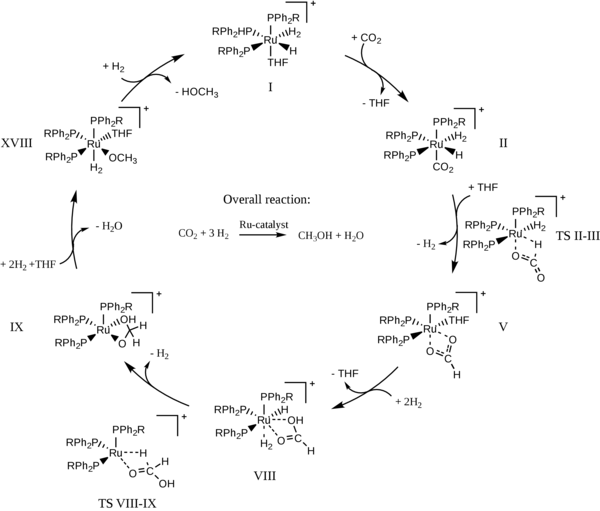
</center>

## Getting started

We import Python classes from `azure.quantum` to create a workspace and the resource estimator target.

In [ ]:
from azure.quantum import Workspace
from azure.quantum.target.microsoft import MicrosoftEstimator

We connect to the Azure Quantum workspace.

In [ ]:
workspace = Workspace (
    resource_id = "",
    location = ""
)

## Extracting resource estimates from logical resource counts

We create a function that creates QIR bitcode from precomputed logical resource estimates.  This function internally creates a small QIR program that leverages the low-level QIR function `__quantum__qis__applyunimplemented__body` that allows to _inject_ logical resource counts to a list of qubits.

In [ ]:
def logical_counts(
    qubit_count: int = 0,
    t_count: int = 0,
    rotation_count: int = 0,
    rotation_depth: int = 0,
    ccz_count: int = 0,
    measurement_count: int = 0
):
    import textwrap

    ir = f"""
        %Array = type opaque
        %Qubit = type opaque
        attributes #1 = {{ "entry_point" }}
        declare %Array* @__quantum__rt__qubit_allocate_array(i64)
        declare void @__quantum__rt__qubit_release_array(%Array*)
        declare void @__quantum__qis__applyunimplemented__body(i64, i64, i64, i64, i64, %Array*)
        define void @Project__Program() #1 {{
        entry:
            %target = call %Array* @__quantum__rt__qubit_allocate_array(i64 {qubit_count})
            call void @__quantum__qis__applyunimplemented__body(i64 {t_count}, i64 {rotation_count}, i64 {rotation_depth}, i64 {ccz_count}, i64 {measurement_count}, %Array* %target)
            call void @__quantum__rt__qubit_release_array(%Array* %target)
            ret void
        }}
        """

    # Support code to transition from pyqir-generator to pyqir package
    try:
        from pyqir.generator import ir_to_bitcode
    except:
        def ir_to_bitcode(ir):
            from pyqir import Context, Module
            return Module.from_ir(Context(), ir).bitcode

    return ir_to_bitcode(textwrap.dedent(ir))

## Running experiments

As configurations for the experiment we use all six pre-defined qubit
parameters.  As pre-defined QEC scheme we are using `surface_code` with
gate-based qubit parameters, and `floquet_code` with Majorana based qubit
parameters.  For all experiments we assume an error budget of 0.01, i.e., 1%. We
leverage the `make_params` function on the `estimator` by setting `num_items` to
6 to create a batching job.  The `error_budget` is set globally for all items,
where as names for `qubit_params` and `qec_scheme` are set individually for each
item.

In [ ]:
estimator = MicrosoftEstimator(workspace)

labels = ["Gate-based µs, 10⁻³", "Gate-based µs, 10⁻⁴", "Gate-based ns, 10⁻³", "Gate-based ns, 10⁻⁴", "Majorana ns, 10⁻⁴", "Majorana ns, 10⁻⁶"]

params = estimator.make_params(num_items=6)
params.error_budget = 0.01
params.items[0].qubit_params.name = "qubit_gate_us_e3"
params.items[1].qubit_params.name = "qubit_gate_us_e4"
params.items[2].qubit_params.name = "qubit_gate_ns_e3"
params.items[3].qubit_params.name = "qubit_gate_ns_e4"
params.items[4].qubit_params.name = "qubit_maj_ns_e4"
params.items[4].qec_scheme.name = "floquet_code"
params.items[5].qubit_params.name = "qubit_maj_ns_e6"
params.items[5].qec_scheme.name = "floquet_code"

Next we are submitting the resource estimation job based on logical resource counts that we have extracted for the chemistry application based on the descriptions in [[Phys. Rev. Research 3, 033055 (2021)](https://doi.org/10.1103/PhysRevResearch.3.033055)] and [arXiv:2110.13439](https://arxiv.org/abs/2110.13439).

In [ ]:
bitcode = logical_counts(
    qubit_count=1318, 
    t_count=120 * 461014,
    rotation_count=446 * 461014,
    rotation_depth=445 * 461014,
    ccz_count=292136 * 461014,
    measurement_count=2982 * 461014)
job = estimator.submit(bitcode, input_params=params)
results = job.get_results()


Finally, we are presenting the experimental results using built-in resource
estimation tables as well as a custom summary table.  For this purpose we are
creating a reusable `dashboard` function that is creating an HTML display from a
pandas data frame and the resource estimation tables.

In [ ]:
def dashboard(results):
    def get_row(result):
        # Extract raw data from result dictionary
        logical_qubits = result["physicalCounts"]["breakdown"]["algorithmicLogicalQubits"]
        logical_depth = result["physicalCounts"]["breakdown"]["logicalDepth"]
        num_tstates = result["physicalCounts"]["breakdown"]["numTstates"]
        code_distance = result["logicalQubit"]["codeDistance"]
        num_tfactories = result["physicalCounts"]["breakdown"]["numTfactories"]
        tfactory_fraction = (result["physicalCounts"]["breakdown"]["physicalQubitsForTfactories"] / result["physicalCounts"]["physicalQubits"]) * 100
        physical_qubits = result["physicalCounts"]["physicalQubits"]
        runtime = result["physicalCounts"]["runtime"]

        # Format some entries
        logical_depth_formatted = f"{logical_depth:.1e}"
        num_tstates_formatted = f"{num_tstates:.1e}"
        tfactory_fraction_formatted = f"{tfactory_fraction:.1f}%"
        physical_qubits_formatted = f"{physical_qubits / 1e6:.2f}M"

        # Make runtime human readable; we find the largest units for which the
        # runtime has a value that is larger than 1.0.  For that unit we are
        # rounding the value and append the unit suffix.
        units = [("nanosecs", 1), ("microsecs", 1000), ("millisecs", 1000), ("secs", 1000), ("mins", 60), ("hours", 60), ("days", 24), ("years", 365)]
        runtime_formatted = runtime
        for idx in range(1, len(units)):
            if runtime_formatted / units[idx][1] < 1.0:
                runtime_formatted = f"{round(runtime_formatted) % units[idx][1]} {units[idx - 1][0]}"
                break
            else:
                runtime_formatted = runtime_formatted / units[idx][1]

        # special case for years
        if isinstance(runtime_formatted, float):
            runtime_formatted = f"{round(runtime_formatted)} {units[-1][0]}"

        # Append all extracted and formatted data to data array
        return (logical_qubits, logical_depth_formatted, num_tstates_formatted, code_distance, num_tfactories, tfactory_fraction_formatted, physical_qubits_formatted, runtime_formatted)

    data = [get_row(results.data(index)) for index in range(len(results))]

    # Create data frame with explicit column names and configuration names extracted from array
    import pandas as pd
    df = pd.DataFrame(data, columns=["Logical qubits", "Logical depth", "T states", "Code distance", "T factories", "T factory fraction", "Physical qubits", "Physical runtime"], index=labels)

    from IPython.display import HTML

    html = f"""
    <div style="padding: 10px; margin: 5px; border: solid 1px; border-radius: 10px"><h3 style="border-bottom: solid 1px; display: inline-block">Summary</h3>{df.to_html()}</div>
    <h3 style="border-bottom: solid 1px; display: inline-block">Details</h3>{results[:]._repr_html_()}
    """

    return HTML(html)

dashboard(results)

The numbers in the table match the numbers in the paper [Assessing requirements
for scaling quantum computers to real-world impact](https://aka.ms/AQ/RE/Paper).
Feel free to use this table as a starting point for your own experiments.  For
example, you can use other or customized qubit parameters.